In [1038]:
import h5py
import pandas as pd
import numpy as np
import math

In [1039]:
# path_to_h5 = 'labels.v001.000_img0068.analysis.h5'

# with h5py.File(path_to_h5, 'r') as f:
#     occupancy_matrix = f['track_occupancy'][:]
#     tracks_matrix = f['tracks'][:]

# print(occupancy_matrix.shape)
# print(tracks_matrix.shape)

In [1040]:
path_to_csv = 'labels.v001.000_img0068.analysis.csv'
df = pd.read_csv(path_to_csv)
# df = df.loc[df['track'] == 'subject']

In [1041]:
def create_affine_transform_matrix(point1, point2):
    # Step 1: Translate point1 to the origin
    translation_matrix_1 = np.array([[1, 0, -point1[0]],
                                     [0, 1, -point1[1]],
                                     [0, 0, 1]])

    # Calculate the new coordinates of point2 after translation
    translated_point2 = np.dot(translation_matrix_1, np.array([point2[0], point2[1], 1]))

    # Step 2: Scale so that the distance between the points is 1
    distance = np.linalg.norm(translated_point2[:2])
#     print(distance)
    
    scale_matrix = np.array([[1/distance, 0, 0],
                             [0, 1/distance, 0],
                             [0, 0, 1]])
    # Step 3: Rotate to align the line connecting the points with the vertical axis
    angle =   np.arctan2(translated_point2[1], translated_point2[0]) + np.pi/2

#     print(angle* 180 / np.pi)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle), 0],
                                [np.sin(angle), np.cos(angle), 0],
                                [0, 0, 1]])
#     print(rotation_matrix)
    # Step 4: Translate point2 to (0, 0.5)
    translation_matrix_2 = np.array([[1, 0, 0],
                                     [0, 1, 0.5],
                                     [0, 0, 1]])

    
        # Combine all transformations
    final_transform_matrix = np.dot(translation_matrix_2,
                                    np.dot(scale_matrix ,
                                           np.dot(np.linalg.inv(rotation_matrix),
                                                  translation_matrix_1)))
    
    return final_transform_matrix


def apply_affine_transform(points, transformation_matrix):
    # Convert points to homogeneous coordinates (add a column of 1's)
    homogeneous_points = np.column_stack([points, np.ones(len(points))])
    # Apply the transformation matrix
    transformed_points = np.dot(homogeneous_points, transformation_matrix.T)

    # Convert back to Cartesian coordinates (remove the last column)
    transformed_points = transformed_points[:, :-1]

    return transformed_points


In [1042]:
data_columns_x = [c for c in df.columns if ('.x' in c) ]
data_columns_y = [c for c in df.columns if ('.y' in c) ]

axis_data_columns_x = ['Neck.x','Trunk.x']
axis_data_columns_y = ['Neck.y','Trunk.y']



In [1043]:
data_columns_x

['Ear_left.x',
 'Ear_right.x',
 'Nose.x',
 'Neck.x',
 'Trunk.x',
 'Lateral_right.x',
 'Lateral_left.x',
 'Tail_base.x']

In [1044]:
n_dim = 2
n_frames = len(df)
n_joints = len(data_columns_x)
data = np.zeros((n_frames, n_dim, n_joints))

for ind, (c_x, c_y) in enumerate(zip(data_columns_x,data_columns_y)):
    x = df[c_x].values
    y = df[c_y].values
    data[:, 0, ind] = x
    data[:, 1, ind] = y
    
    

In [1045]:
n_frames

788

In [1046]:
nodes = [
    'Ear_left', 
    'Ear_right',
    'Nose',
    'Neck',
    'Trunk',
    'Lateral_right',
    'Lateral_left',
    'Tail_base']

nodes_to_ind = {n:ind for ind,n in enumerate(nodes)}

skeleton = [
    ('Neck', 'Ear_left'),
    ('Neck', 'Ear_right'),
    ('Neck', 'Nose'),
    ('Trunk', 'Neck'),
    ('Trunk', 'Lateral_right'),
    ('Trunk', 'Lateral_left'),
    ('Trunk', 'Tail_base')   
]

edges = np.array([(nodes_to_ind[e1], nodes_to_ind[e2]) for e1, e2 in skeleton]).reshape(-1,2)
edges

array([[3, 0],
       [3, 1],
       [3, 2],
       [4, 3],
       [4, 5],
       [4, 6],
       [4, 7]])

In [1047]:


all_frames = []
for frame_i in range(n_frames):
    
    point1 = data[frame_i,:,3]
    point2 = data[frame_i,:,4]

    transform_matrix = create_affine_transform_matrix(point1, point2)
    
    test_data = data[frame_i,:,:]
    point_to_transform = test_data.T
    transformed_point = apply_affine_transform(point_to_transform, transform_matrix)
    temp_df = pd.DataFrame(transformed_point, columns=['X', 'Y'])
    temp_df['Joint'] = nodes
    temp_df['Frame'] = frame_i
    all_frames.append(temp_df)
df_trnasformed = pd.concat(all_frames)

In [1088]:
import matplotlib.pyplot as plt

def plot_side_by_side(joints1, edges1, joints2, edges2, labels=None, match_axis=False):
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    if labels is None:
        labels = ['Set1','Set2']
    # Plot the first set of joints and edges on the first subplot
    axs[0].scatter(*zip(*joints1), c='b', label='Joints 1')
    for edge in edges1:
        axs[0].plot(*zip(*[joints1[i] for i in edge]), c='b', linestyle='--', alpha=0.7)
    axs[0].set_title(labels[0])
    axs[0].legend()

    # Plot the second set of joints and edges on the second subplot
    axs[1].scatter(*zip(*joints2), c='r', label='Joints 2')
    for edge in edges2:
        axs[1].plot(*zip(*[joints2[i] for i in edge]), c='r', linestyle='--', alpha=0.7)
    axs[1].set_title(labels[1])
    axs[1].legend()

#     # Set a common axis limit for both subplots
    if match_axis:
        minx, miny = np.min(np.vstack([set1, set2]), axis=0)-1
        maxx, maxy = np.max(np.vstack([set1, set2]), axis=0)+1
        axs[0].set_xlim(minx,maxx)
        axs[0].set_ylim(miny,maxy)
        axs[1].set_xlim(minx,maxx)
        axs[1].set_ylim(miny,maxy)

    # Display the plots
    plt.show()

# # Example usage:
# joints_set1 = [(1, 1), (2, 2), (3, 3), (4, 4)]
# edges_set1 = [(0, 1), (1, 2), (2, 3)]

# joints_set2 = [(0, 0), (1, 1), (2, 2)]
# edges_set2 = [(0, 1), (1, 2)]

frame=1
set1 = data[frame,:,:].T
set2 = set2 = df_trnasformed.loc[df_trnasformed['Frame']==frame,['X','Y']].values

plot_side_by_side(set1, edges, set2, edges)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [1049]:
minx, miny = np.min(np.vstack([set1, set2]), axis=0)-1
maxx, maxy = np.max(np.vstack([set1, set2]), axis=0)+1

In [1050]:
np.min(np.min(set1, axis=0)[0], np.min(set2, axis=0)[0]) - 1, np.max(max(set1, axis=0)[0], np.max(set2, axis=0)[0])

TypeError: 'numpy.float64' object cannot be interpreted as an integer

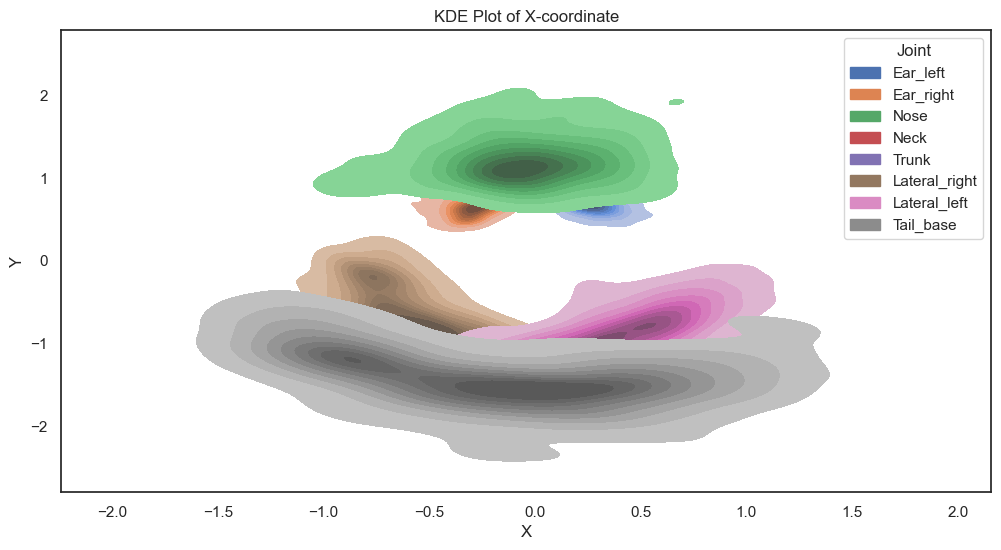

In [1051]:
import seaborn as sns

# # Create separate DataFrames for X and Y coordinates
# x_df = pivoted_df[['Frame', 'Joint', 'X-coordinate']]
# y_df = pivoted_df[['Frame', 'Joint', 'Y-coordinate']]

# Set up Seaborn style
sns.set(style="white")

# Initialize a figure for X-coordinate KDE plot
plt.figure(figsize=(12, 6))
plt.title('KDE Plot of X-coordinate')

# Create a KDE plot for X-coordinate
sns.kdeplot(data=df_trnasformed, x='X', y='Y', hue='Joint', fill=True, common_norm=False)

# Show the X-coordinate KDE plot
plt.show()

# # Initialize a figure for Y-coordinate KDE plot
# plt.figure(figsize=(12, 6))
# plt.title('KDE Plot of Y-coordinate')

# # Create a KDE plot for Y-coordinate
# sns.kdeplot(data=y_df, x='X-coordinate', y='Y-coordinate', hue='Joint', fill=True, common_norm=False)

# # Show the Y-coordinate KDE plot
# plt.show()

In [1052]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import lr_scheduler
from torch.distributions import Normal
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn.functional as F

In [1053]:
num_joints = number_of_joints

In [ ]:

def masked_vae_loss(reconstruction, input_data, mu, log_var, mask, warm_up_ratio):
    """
    Compute the loss function for a masked Variational Autoencoder (VAE).

    Parameters:
        - reconstruction: The reconstructed data from the VAE
        - input_data: The original input data
        - mu: The mean of the latent space
        - log_var: The log variance of the latent space
        - mask: The mask indicating which elements are masked (0 for masked, 1 for unmasked)

    Returns:
        - loss: The masked VAE loss
    """
    input_data = input_data.unsqueeze(1).permute(0, 2, 1)
    # Reconstruction loss (MSE) only for unmasked elements
    unmasked_reconstruction = reconstruction * mask
    unmasked_input_data = input_data * mask
    reconstruction_loss = F.mse_loss(unmasked_reconstruction, unmasked_input_data, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    kl_loss *= warm_up_ratio
    # Combine the reconstruction loss and KL divergence loss
    loss = reconstruction_loss + kl_loss

    return loss




In [1436]:

# class MaskedVAE(nn.Module):
#     def __init__(self, input_dim, latent_dim, filter_sizes, dropout_prob=0.2, mask_prob=0.5):
#         super(MaskedVAE, self).__init__()

#         self.latent_dim = latent_dim
#         self.mask_prob = mask_prob
        
#         # Encoder
#         encoder_layers = []
#         prev_dim = input_dim
#         encoder_skip_connections = []
        
#         for dim in filter_sizes:
#             encoder_layers.append(nn.Conv1d(prev_dim, dim, kernel_size=3, stride=1, padding=1))
#             encoder_layers.append(nn.ReLU())
#             encoder_layers.append(nn.BatchNorm1d(dim))
#             encoder_layers.append(nn.Dropout(p=dropout_prob))
                        
#             encoder_skip_connections.append(nn.Conv1d(prev_dim, dim, kernel_size=1))
            
#             prev_dim = dim
            
#         encoder_layers.append(nn.Conv1d(prev_dim, latent_dim * 2, kernel_size=3, stride=1, padding=1))
#         self.encoder = nn.Sequential(*encoder_layers)
#         self.encoder_skip_connections = nn.ModuleList(encoder_skip_connections)
        
#         # Decoder
#         decoder_layers = []
#         prev_dim = latent_dim
#         decoder_skip_connections = []
        
#         for dim in reversed(filter_sizes):
#             decoder_layers.append(nn.Conv1d(prev_dim, dim, kernel_size=3, stride=1, padding=1))
#             decoder_layers.append(nn.ReLU())
#             decoder_layers.append(nn.BatchNorm1d(dim))
#             decoder_layers.append(nn.Dropout(p=dropout_prob))
                        
#             decoder_skip_connections.append(nn.Conv1d(prev_dim, dim, kernel_size=1))
#             prev_dim = dim
            
#         decoder_layers.append(nn.Conv1d(prev_dim, input_dim, kernel_size=3, stride=1, padding=1))
#         self.decoder = nn.Sequential(*decoder_layers)
#         self.decoder_skip_connections = nn.ModuleList(decoder_skip_connections)

#         # Initialize weights using standard initialization methods
#         self.apply(self.init_weights)

#     def forward(self, x):
#         # Apply masking to the input data
#         x, mask = self.mask_data(x)

#         # Unsqueeze and permute the input tensor to match Conv1D dimensions
#         x = x.unsqueeze(1).permute(0, 2, 1)

#         # Encode input data to obtain mean and log variance of the latent space
#         encoder_outputs = []
#         for i, encoder_layer in enumerate(self.encoder):
#             if i < len(self.encoder) - 1:
#                 # Apply skip connection from the corresponding encoder layer
#                 skip_x = x
#             x = encoder_layer(x)
# #             print(f'skip encoder len:{len(self.encoder_skip_connections)}, i:{i}')
            
#             if i < len(self.encoder_skip_connections) -1 and (i%4==0):
#                 x = x + self.encoder_skip_connections[i//4](skip_x)
#             encoder_outputs.append(x)

#         # Reparameterization trick
#         encoded = encoder_outputs[-1]
#         mu, log_var = encoded[:, :self.latent_dim], encoded[:, self.latent_dim:]
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         z = mu + eps * std

#         # Decode latent space to reconstruct input
#         decoder_outputs = []
#         for i, decoder_layer in enumerate(self.decoder):
#             if i < len(self.decoder) - 1:
#                 # Apply skip connection from the corresponding decoder layer
#                 skip_z = z
#             z = decoder_layer(z)
#             if i < len(self.decoder_skip_connections) - 1:
#                 print(len(self.decoder_skip_connections))
#                 print(i)
#                 z = z + self.decoder_skip_connections[i](skip_z)
#             decoder_outputs.append(z)

#         # Reverse the process by going backward through encoder outputs
#         for i in reversed(range(len(encoder_outputs) - 1)):
#             decoder_outputs.append(decoder_outputs[-1] + self.encoder_skip_connections[i//4](encoder_outputs[i//4]))

#         # Reverse the list to get the correct order
#         decoder_outputs.reverse()

#         # Final reconstruction
#         reconstruction = decoder_outputs[-1]

#         return reconstruction, mu, log_var, mask

    
#     def init_weights(self, m):
#         if isinstance(m, nn.Conv1d):
#             nn.init.kaiming_normal_(m.weight)
#             if m.bias is not None:
#                 nn.init.zeros_(m.bias)
                
#     def mask_data(self, x):
#         mask = (torch.rand(x.size()) > self.mask_prob).float()
#         return x * mask, mask
    
# def masked_vae_loss(reconstruction, input_data, mu, log_var, mask, warm_up_ratio):
#     """
#     Compute the loss function for a masked Variational Autoencoder (VAE).

#     Parameters:
#         - reconstruction: The reconstructed data from the VAE
#         - input_data: The original input data
#         - mu: The mean of the latent space
#         - log_var: The log variance of the latent space
#         - mask: The mask indicating which elements are masked (0 for masked, 1 for unmasked)

#     Returns:
#         - loss: The masked VAE loss
#     """
#     input_data = input_data.unsqueeze(1).permute(0, 2, 1)
#     # Reconstruction loss (MSE) only for unmasked elements
#     unmasked_reconstruction = reconstruction * mask
#     unmasked_input_data = input_data * mask
#     reconstruction_loss = F.mse_loss(unmasked_reconstruction, unmasked_input_data, reduction='sum')

#     # KL divergence loss
#     kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
#     kl_loss *= warm_up_ratio
#     # Combine the reconstruction loss and KL divergence loss
#     loss = reconstruction_loss + kl_loss

#     return loss




In [1426]:
# Example usage:
input_dim = 2*num_joints  # Adjust as needed
latent_dim = 8  # Adjust as needed
hidden_dims_encoder = [32, 32, 32]  # User-defined hidden layer sizes for encoder
# hidden_dims_decoder = [32, 32, 32]  # User-defined hidden layer sizes for encoder
dropout_prob = 0.5  # Adjust dropout probability as needed
mask_prob = 0.5 

vae = MaskedVAE(input_dim, latent_dim, hidden_dims_encoder, dropout_prob, mask_prob)

# Accessing the encoder and decoder separately (if needed)
encoder = vae.encoder
decoder = vae.decoder

# Print the model architecture
print(vae)

MaskedVAE(
  (encoder): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): ReLU()
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (encoder_skip_connections): ModuleList(
    (0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
    (1): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (decoder): Sequential(
    (0): Conv

In [1427]:
# from torch.nn import ModuleList, Module, Conv1d, ReLU, MaxPool1d, ConvTranspose1d
# # 

In [1428]:
# class Block(Module):
#     def __init__(self, inChannels, outChannels):
#         super().__init__()
#         # store the convolution and RELU layers
        
#         self.conv1 = Conv1d(inChannels, outChannels, 1)
#         self.relu = ReLU()
#         self.conv2 = Conv1d(outChannels, outChannels, 1)
    
#     def forward(self, x):
#         # apply CONV => RELU => CONV block to the inputs and return it
        
#         return self.conv2(self.relu(self.conv1(x)))



In [1429]:
class Encoder(Module):
    def __init__(self, channels=(16, 32)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        self.pool = MaxPool1d(2)
    def forward(self, x):
       

        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for i, block in enumerate(self.encBlocks):
            # pass the inputs through the current encoder block, store
            # the outputs, and then apply maxpooling on the output
            
            x = block(x)
            
            blockOutputs.append(x)
            x = self.pool(x)
        # return the list containing the intermediate outputs
        return blockOutputs

In [1430]:
# class Decoder(Module):
#     def __init__(self, channels=(32, 16)):
#         super().__init__()
#         # initialize the number of channels, upsampler blocks, and
#         # decoder blocks
#         self.channels = channels
#         self.upconvs = ModuleList(
#             [ConvTranspose1d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
#         self.dec_blocks = ModuleList( [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
#     def forward(self, x, encFeatures):
#         # loop through the number of channels
#         for i in range(len(self.channels) - 1):
#             # pass the inputs through the upsampler blocks
#             x = self.upconvs[i](x)
#             # crop the current features from the encoder blocks,
#             # concatenate them with the current upsampled features,
#             # and pass the concatenated output through the current
#             # decoder block
# #             encFeat = self.crop(encFeatures[i], x)
#             encFeat = encFeatures[i]
#             x = torch.cat([x, encFeat], dim=1)
#             x = self.dec_blocks[i](x)
#         # return the final decoder output
#         return x
# #     def crop(self, encFeatures, x):
# #         # grab the dimensions of the inputs, and crop the encoder
# #         # features to match the dimensions
# #         (_, _, H, W) = x.shape
# #         encFeatures = CenterCrop([H, W])(encFeatures)
# #         # return the cropped features
# #         return encFeatures

In [1431]:
# class UNet(nn.Module):
#     def __init__(self, encChannels=(1, 16, 32, 64),
#              decChannels=(64, 32, 16),
#                  nbClasses=1, retainDim=True,
#                  outSize=(1,16)):
#         super().__init__()
#         # initialize the encoder and decoder
#         self.encoder = Encoder(encChannels)
#         self.decoder = Decoder(decChannels)
#         # initialize the regression head and store the class variables
#         self.head = Conv1d(decChannels[-1], nbClasses, 1)
#         self.retainDim = retainDim
#         self.outSize = outSize

#     def forward(self, x):
#         x = x.unsqueeze(1).permute(0,1,2)
#         print(x.shape)
#         # grab the features from the encoder
#         encFeatures = self.encoder(x)
#         # pass the encoder features through decoder making sure that
#         # their dimensions are suited for concatenation
#         decFeatures = self.decoder(encFeatures[::-1][0],
#                                    encFeatures[::-1][1:])
#         # pass the decoder features through the regression head to
#         # obtain the segmentation mask
#         map = self.head(decFeatures)
#         # check to see if we are retaining the original output
#         # dimensions and if so, then resize the output to match them
#         if self.retainDim:
#             map = F.interpolate(map, self.outSize)
#             # return the segmentation map
#             return map

In [1432]:
# unet = UNet()

In [1433]:
# unet(batch)

In [1434]:
# # Example usage:
# input_channels = number_of_joints* number_of_dim  # Input channels 16
# out_channels = number_of_joints* number_of_dim  # Output channels
# num_blocks = 1  # Number of encoder and decoder blocks
# num_layers_per_block = 2  # Number of layers in each block
# dropout_prob = 0.2  # Dropout probability
# mask_percentage = 0.2  # Adjust the masking percentage as needed
# batch_size = 32

# unet = UNet(input_channels, out_channels, num_blocks, num_layers_per_block, dropout_prob, mask_percentage)
# input_data = torch.rand(32, input_channels)  # Example input with shape (batch_size, channels, seq_len)

# output = unet(input_data)
# print("U-Net Model:")
# print(unet)
# print("\nInput Data Shape:", input_data.shape)
# print("Output Shape:", output.shape)

In [1435]:
# Define optimizer with weight decay and initial learning rate
initial_lr = 0.0001
weight_decay = 1e-5
optimizer = optim.Adam(vae.parameters(), lr=initial_lr, weight_decay=weight_decay)
param_group['lr'] = initial_lr

# Split data into train and validation sets
# data = torch.randn(788, 2, 8)  # Replace with your data
data = data_model.astype(np.float32)
train_ratio = 0.8  # Adjust the ratio as needed
train_size = int(train_ratio * len(data))
val_size = len(data) - train_size
train_data, val_data = random_split(data, [train_size, val_size])

# Create DataLoader for train and validation sets
batch_size = 32  # Adjust the batch size as needed
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Training parameters
num_epochs = 1500  # Adjust as needed
lr_decay_step = 300  # Learning rate decay step
lr_decay_rate = 0.5  # Learning rate decay rate
early_stop_patience = 20  # Number of epochs without improvement before early stopping
warm_up = 200
display_interval = 100

# Initialize early stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0
warm_up_value = warm_up
# Training loop
vae.train()  # Set the model to training mode to enable dropout
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0.0
    if warm_up_value >= 1:
        if warm_up_value == 1:
            print('Warm up complete')
        warm_up_value -= 1
    
    
    # Learning rate decay
    if (epoch + 1) % lr_decay_step == 0 and warm_up_value<1:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_decay_rate
    
    for batch in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, log_var, mask = vae(batch)
        loss = masked_vae_loss(reconstruction, batch, mu, log_var, mask, (warm_up - warm_up_value)/warm_up)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Display loss every x epochs (replace x with your desired value)
    currentlr = param_group['lr']
    if (epoch + 1) % display_interval == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {total_loss / len(train_loader):.4f}, lr:{currentlr}')
    
    # Validation loss (optional)
    if (epoch + 1) % display_interval == 0:
        
        vae.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_loader:
                val_reconstruction, val_mu, val_log_var, val_mask = vae(val_batch)
                val_loss += masked_vae_loss(val_reconstruction, val_batch, val_mu, val_log_var, val_mask, (warm_up - warm_up_value)/warm_up).item()
        print(f'Validation Loss: {val_loss / len(val_loader):.4f}')
        
        if warm_up_value < 1:
            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                best_model = vae
            else:
                epochs_without_improvement += 1
                print(f'No improvments for {epochs_without_improvement}/{early_stop_patience}')
                if epochs_without_improvement >= early_stop_patience:
                    print(f'Early stopping after {epoch + 1} epochs without improvement.')
                    break

print('Training complete.')

3
0
3
1


RuntimeError: The size of tensor a (16) must match the size of tensor b (32) at non-singleton dimension 1

In [1438]:
# def get_preds(vae_model, input_data):
#     """
#     Generate predictions using a Variational Autoencoder (VAE) model.

#     Parameters:
#         - vae_model: Trained VAE model
#         - input_data: Input data for which predictions are generated (numpy array or PyTorch tensor)

#     Returns:
#         - reconstructed_data: Predicted/reconstructed data
#     """
#     # Convert input data to PyTorch tensor if it's not already
#     if not isinstance(input_data, torch.Tensor):
#         input_data = torch.tensor(input_data, dtype=torch.float32)

#     # Set the model to evaluation mode
#     vae_model.eval()

#     # Disable gradient computation during inference
#     with torch.no_grad():
#         # Pass the input data through the VAE model to generate predictions
#         reconstructed_data, _, _, _ = vae(input_data)

#     # Return the reconstructed data as a numpy array
#     return reconstructed_data.numpy()

In [1437]:
# def matrix_to_df(matrix):
#     matrix = reconstructed_data
#     matrix = matrix.reshape(-1,number_of_dim, number_of_joints)
#     x_data = matrix[:, 0, :]
#     y_data = matrix[:, 1, :]

#     x_data_df = pd.DataFrame(x_data, columns=nodes)
#     y_data_df = pd.DataFrame(y_data, columns=nodes)

#     x_data_df['Frame'] = range(number_of_frames)
#     y_data_df['Frame'] = range(number_of_frames)

#     # Reset the index to add a 'Frame' column
#     x_data_df.reset_index(inplace=True, drop=True)
#     y_data_df.reset_index(inplace=True, drop=True)

#     # Use the 'melt' function to reshape the DataFrame
#     x_data_df = pd.melt(x_data_df, id_vars=['Frame'], var_name='Joint', value_name='X')
#     y_data_df = pd.melt(y_data_df, id_vars=['Frame'], var_name='Joint', value_name='Y')

#     x_data_df = x_data_df.set_index(['Frame','Joint'])
#     y_data_df = y_data_df.set_index(['Frame','Joint'])

#     x_data_df = x_data_df.join(y_data_df)
#     return x_data_df.reset_index()
    


In [1072]:
reconstructed_data = get_preds(vae, data_model)
reconstructed_data_df =  matrix_to_df(reconstructed_data)
reconstructed_data_df

,Frame,Joint,X,Y
0,0,Ear_left,0.270129,-4.634028e-07
1,1,Ear_left,0.270436,-6.008478e-06
2,2,Ear_left,0.270185,-1.488265e-05
3,3,Ear_left,0.270489,-4.110798e-06
4,4,Ear_left,0.270300,-1.180154e-05
...,...,...,...,...
6299,783,Tail_base,0.500009,-1.393894e+00
6300,784,Tail_base,0.500024,-1.353557e+00
6301,785,Tail_base,0.499995,-1.429877e+00
6302,786,Tail_base,0.499996,-1.370930e+00


In [1060]:
# # Define a custom neural network model for the joints with customizable layers
# class JointModel(nn.Module):
#     def __init__(self, input_dim, output_dim, hidden_layers=[], batch_norm=True, weight_decay=0.0, dropout_prob=0.0):
#         super(JointModel, self).__init__()
        
#         layers = []
#         prev_layer_size = input_dim
        
#         # Add Batch Normalization if specified
#         if batch_norm:
#             layers.append(nn.BatchNorm1d(input_dim))
        
#         for layer_size in hidden_layers:
#             layers.append(nn.Linear(prev_layer_size, layer_size))
#             layers.append(nn.ReLU())
            
#             # Add Batch Normalization if specified
#             if batch_norm:
#                 layers.append(nn.BatchNorm1d(layer_size))
            
#             # Add Dropout if specified
#             if dropout_prob > 0:
#                 layers.append(nn.Dropout(dropout_prob))
            
#             prev_layer_size = layer_size
#         layers.append(nn.Linear(prev_layer_size, output_dim))
        
#         self.layers = nn.Sequential(*layers)

#         # Apply He initialization to the layers
#         self.apply(self.init_weights)
        
#         # Add L2 regularization (weight decay) to all linear layers if weight_decay is specified
#         if weight_decay > 0:
#             for layer in self.layers:
#                 if isinstance(layer, nn.Linear):
#                     layer.weight_decay = weight_decay

#     def init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

#     def forward(self, x):
#         return self.layers(x)

In [888]:
# def get_joint_inx(joint_ind, number_of_joints=number_of_joints):
#     assert joint_ind<number_of_joints, f'Joint number {joint_ind} out of range {number_of_joints-1}'
#     x_index = [i for i in range(number_of_joints*2) if i!=joint_ind*2 and i!=joint_ind*2+1]
#     y_index = [joint*2 ,joint*2+1]
#     return x_index, y_index

# get_joint_inx(joint_ind=7, number_of_joints=number_of_joints)

In [845]:
# models = {}
# scalers = {}
# joint_data_dict = {}

In [846]:
# # Specify the number of hidden layers and their sizes
# hidden_layers_config = [64, 64]  # Adjust as needed
# # Early stopping parameters
# patience = 200  # Number of epochs to wait for validation loss improvement

# # Regularization parameter (L2 weight decay)
# weight_decay = 1e-5  # Adjust as needed

# # Dropout probability
# dropout_prob = 0.2  # Adjust as needed

# # Learning rate and learning rate scheduler parameters
# initial_lr = 0.001  # Initial learning rate
# lr_decay_factor = 0.5  # Factor by which learning rate will be reduced
# lr_decay_step_size = 200  # Number of epochs after which learning rate will be reduced


# for joint in range(number_of_joints):
#     if joint in [3,4]:
#         continue
    
#     best_val_loss = float('inf')
#     early_stopping_counter = 0
    
#     if joint in joint_data_dict:
#         X_train, X_test, y_train, y_test = joint_data_dict[joint]
#     else:

#         x_index, y_index = get_joint_inx(joint, number_of_joints=number_of_joints)

#         # Extract X and Y coordinates
#         X = data_model[:,x_index]
#         y = data_model[:,y_index]

#         # Split the data into training and testing sets
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#         # Standardize the data using StandardScaler
#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train)
#         X_test = scaler.transform(X_test)
        
#         joint_data_dict[joint] = (X_train, X_test, y_train, y_test)
    
#     # Instantiate the model with customizable layers
#     input_dim = X_train.shape[1]
#     output_dim = y_train.shape[1]
#     model = JointModel(input_dim, output_dim, hidden_layers=hidden_layers_config, batch_norm=True, weight_decay=weight_decay, dropout_prob=dropout_prob)
#     best_model = model
    
#     # Define loss function and optimizer
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    
#     # Learning rate scheduler
#     scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_factor)
    
    
#      # Training loop
#     num_epochs = 5000  # Adjust as needed
#     for epoch in range(num_epochs):
#         # Convert data to PyTorch tensors
#         X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#         y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        
#         # Forward pass
#         outputs = model(X_train_tensor)
#         loss = criterion(outputs, y_train_tensor)
    
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#         # Print loss at certain intervals
#         if (epoch + 1) % 100 == 0:
#             print(f'Joint {joint}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
#         # Validation loss
#         X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
#         y_val_tensor = torch.tensor(y_test, dtype=torch.float32)
#         val_outputs = model(X_val_tensor)
#         val_loss = criterion(val_outputs, y_val_tensor)
        
#         # Check for early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             early_stopping_counter = 0
#             best_model = model
#         else:
#             early_stopping_counter += 1
        
#         if early_stopping_counter >= patience:
#             print(f'Early stopping for Joint {joint} at epoch {epoch + 1} due to no improvement in validation loss.')
#             break
    
#     # Save the trained model and scaler for the current joint
#     models[joint] = model
#     scalers[joint] = scaler
    
#     # Save the trained model and scaler for the current joint
#     models[joint] = best_model
#     scalers[joint] = scaler

In [847]:
def get_preds(joints, joint_ind):
    x_ind, y_ind = get_joint_inx(joint_ind, number_of_joints=number_of_joints)
    x = joints[:, x_ind]
    y = joints[:, y_ind]
    model = models[joint_ind]
    scaler = scalers[joint_ind]
    x = scaler.transform(x)
    x = torch.tensor(x, dtype=torch.float32)
    model.eval()
    ypred = model(x).detach().numpy()
    
    x_y = y[:,0]
    y_y = y[:,1]
    
#     x_ypred =  ypred[:,0]
#     y_ypred = ypred[:,1]
#     return pd.DataFrame(zip(x_y, x_ypred, y_y, y_ypred), columns=['x','xp','y','yp'])
    return ypred
all_predicted_list = []
predicted = np.zeros_like(data_model)
for joint_ind in range(number_of_joints):
    if joint_ind in [3,4]:
        y_pred = data_model[:,joint_ind*2:joint_ind*2+2]
    else:
        y_pred = get_preds(data_model, joint_ind)
    predicted[:,joint_ind*2:joint_ind*2+2] = y_pred
    
    temp_df = pd.DataFrame(y_pred, columns=['X', 'Y'])
    temp_df['Joint'] = nodes[joint_ind]
    temp_df['Frame'] = range(number_of_frames)
    all_predicted_list.append(temp_df)
df_predicted = pd.concat(all_predicted_list)    

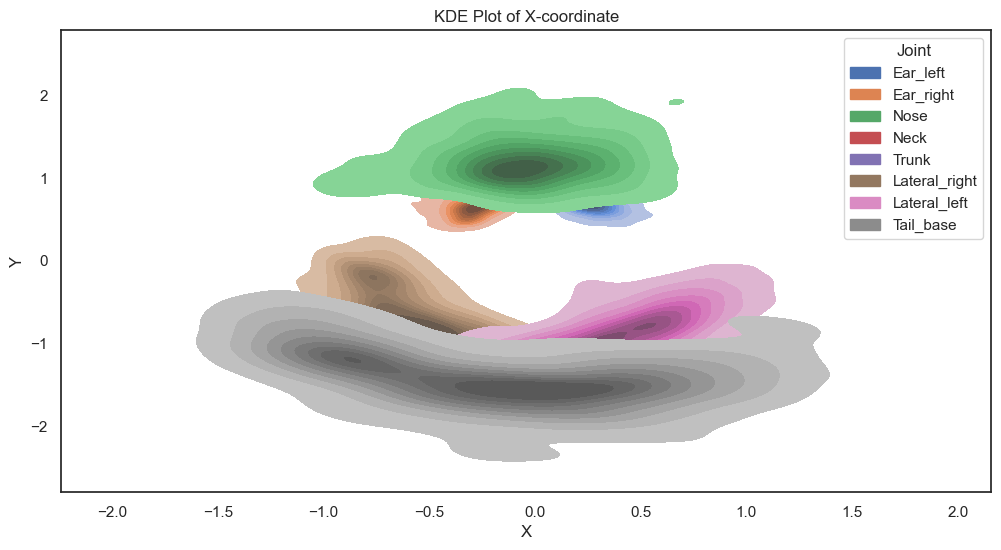

In [848]:
sns.set(style="white")

# Initialize a figure for X-coordinate KDE plot
plt.figure(figsize=(12, 6))
plt.title('KDE Plot of X-coordinate')

# Create a KDE plot for X-coordinate
s = sns.kdeplot(data=df_trnasformed, x='X', y='Y', hue='Joint', fill=True, common_norm=False)


# Show the X-coordinate KDE plot
plt.show()




In [849]:
df_predicted

,X,Y,Joint,Frame
0,0.188166,0.685883,Ear_left,0
1,0.243883,0.758708,Ear_left,1
2,0.123134,0.781637,Ear_left,2
3,0.374265,0.667827,Ear_left,3
4,0.326564,0.848036,Ear_left,4
...,...,...,...,...
783,-0.425406,-1.756234,Tail_base,783
784,-0.357403,-1.451074,Tail_base,784
785,-0.455115,-1.448377,Tail_base,785
786,-0.595364,-1.433337,Tail_base,786


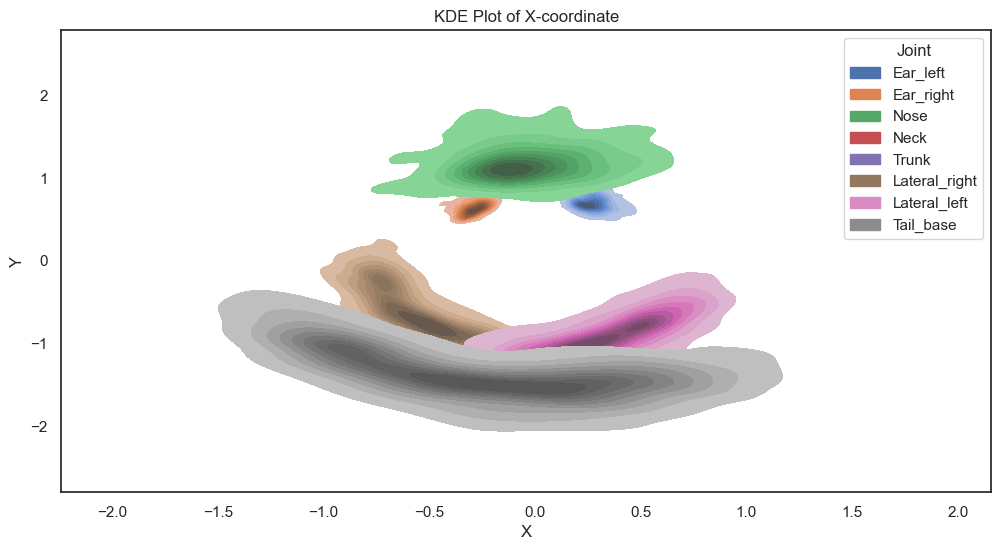

In [850]:
sns.set(style="white")

# Initialize a figure for X-coordinate KDE plot
plt.figure(figsize=(12, 6))
plt.title('KDE Plot of X-coordinate')

# Create a KDE plot for X-coordinate
s2 = sns.kdeplot(data=df_predicted, x='X', y='Y', hue='Joint', fill=True, common_norm=False)

s2.set_xlim(s.get_xlim())
s2.set_ylim(s.get_ylim())

# Show the X-coordinate KDE plot
plt.show()

In [1076]:
reconstructed_data_df

,Frame,Joint,X,Y
0,0,Ear_left,0.270129,-4.634028e-07
1,1,Ear_left,0.270436,-6.008478e-06
2,2,Ear_left,0.270185,-1.488265e-05
3,3,Ear_left,0.270489,-4.110798e-06
4,4,Ear_left,0.270300,-1.180154e-05
...,...,...,...,...
6299,783,Tail_base,0.500009,-1.393894e+00
6300,784,Tail_base,0.500024,-1.353557e+00
6301,785,Tail_base,0.499995,-1.429877e+00
6302,786,Tail_base,0.499996,-1.370930e+00


In [1089]:
 reconstructed_data_df.loc[reconstructed_data_df['Frame']==frame,['X','Y']]

,X,Y
1,0.270436,-0.000006
789,0.693381,-0.500000
1577,-0.283623,-0.538211
2365,0.649860,-0.664508
3153,-0.038187,0.390351
3941,1.174789,-0.853154
4729,0.000010,-0.186629
5517,0.499988,-1.405136


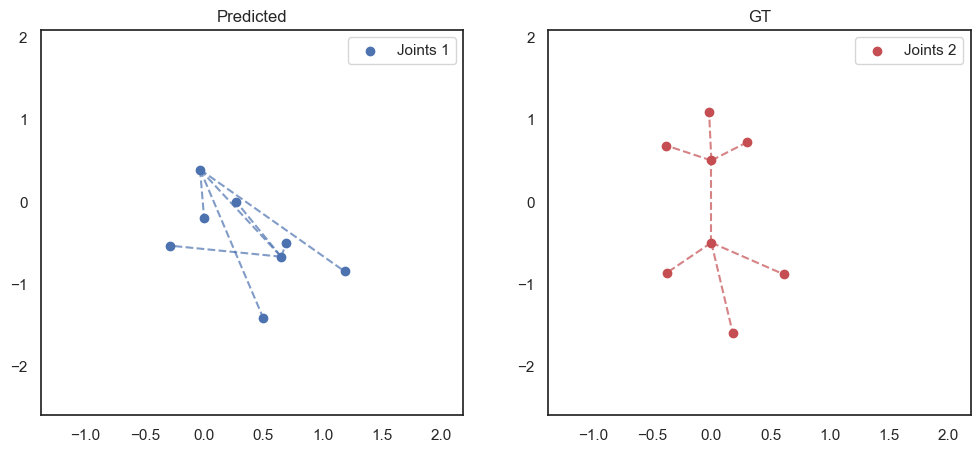

In [1087]:
frame=200
set1 = reconstructed_data_df.loc[reconstructed_data_df['Frame']==frame,['X','Y']].values
set2 = df_trnasformed.loc[df_trnasformed['Frame']==frame,['X','Y']].values

plot_side_by_side(set1, edges, set2, edges,labels=['Predicted','GT'], match_axis=True)